#  Data & Annotation

In this section we load the dataset, check its shape, and print out  the class distribution.

Then we map numeric labels to emotion names.

Then we remove corrupted or incorrectly labeled entries

In [1]:
!pip install -U deeplake

In [2]:
# GETTING THE NEEDED LIBRARIES
import hub 
import deeplake
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter

C:\Users\user\anaconda3\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.14) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [3]:
# Load the FER2013 training dataset
ds = deeplake.load('hub://activeloop/fer2013-train', read_only=True)

-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-train



/

hub://activeloop/fer2013-train loaded successfully.



In [4]:
# Look at the data
print(ds)  
print("Sample keys:", ds.tensors)  

Dataset(path='hub://activeloop/fer2013-train', read_only=True, tensors=['images', 'labels'])
Sample keys: {'images': Tensor(key='images'), 'labels': Tensor(key='labels')}


In [5]:
# Check class distribution
labels = np.array([int(lbl.numpy()[0]) for lbl in ds.labels])
class_counts = Counter(labels)
print("Class distribution:", class_counts)

# Map numeric labels to emotion names
emotion_map = {
    0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 
    4: "Sad", 5: "Surprise", 6: "Neutral"
}

Class distribution: Counter({3: 7215, 6: 4965, 4: 4830, 2: 4097, 0: 3995, 5: 3171, 1: 436})


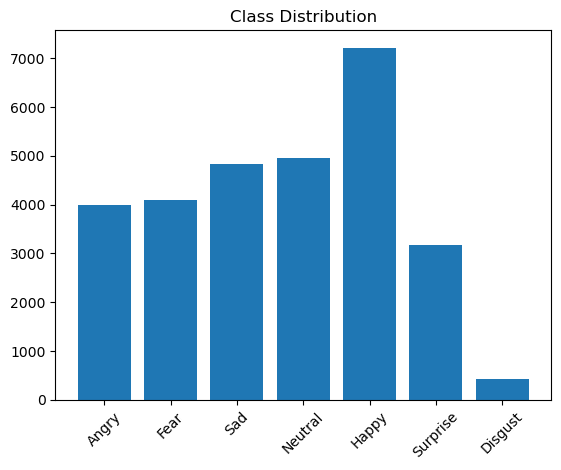

In [6]:
# Plot class balance
plt.bar([emotion_map[i] for i in class_counts.keys()], class_counts.values())
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

In [7]:
# Remove samples with invalid labels or corrupted images
clean_indices = [i for i in range(len(ds)) if ds.labels[i].numpy()[0] in emotion_map]
print(f"Valid samples: {len(clean_indices)} / {len(ds)}")

C:\Users\user\anaconda3\Lib\site-packages\deeplake\core\tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Valid samples: 28709 / 28709


# Data Preprocessing & Augmentation

In this section we resize and normalize images.

convert grayscale images to (48,48,1).

One-hot encode labels for training.

Set up augmentation for more robust training.

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
IMG_SIZE = (48, 48)

# Convert dataset to NumPy arrays
X = np.array([np.squeeze(ds.images[i].numpy()) for i in clean_indices])
y = np.array([int(ds.labels[i].numpy()[0]) for i in clean_indices])

In [10]:
# Normalize (0-255 → 0-1)
X = X / 255.0
X = np.expand_dims(X, -1)  # Adding the channel dimension for CNN

In [11]:
# One-hot encode labels
y = tf.keras.utils.to_categorical(y, num_classes=len(emotion_map))

In [12]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X)

# Model Building & Training

In this section we split the dataset into training and validation sets

Set up data augmentation for training

Keep validation set clean

Build the CNN model

Compile the model

Train the model

Train CNN with class weights (handles imbalance)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

In [14]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [15]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
train_gen = train_datagen.flow(X_train, y_train, batch_size=64)

In [16]:
# Validation generator (no augmentation, just normalization)
val_datagen = ImageDataGenerator()
val_gen = val_datagen.flow(X_val, y_val, batch_size=64)

In [17]:
# CNN model
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(48,48,1)),
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(emotion_map), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
#Compute class weights
y_train_classes = np.argmax(y_train, axis=1)  # convert one-hot to integer labels
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_classes),
    y=y_train_classes
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 1.0265957446808511, 1: 9.401146131805158, 2: 1.0012206286237413, 3: 0.5684338184338185, 4: 0.849120082815735, 5: 1.2932597556168703, 6: 0.8260322255790534}


In [19]:
# Train the model
history = model.fit(train_gen, epochs=15, validation_data=val_gen, class_weight=class_weights)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 77s 191ms/step - accuracy: 0.1423 - loss: 2.2234 - val_accuracy: 0.2163 - val_loss: 1.8580
Epoch 2/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 63s 175ms/step - accuracy: 0.1346 - loss: 1.9017 - val_accuracy: 0.2584 - val_loss: 1.8689
Epoch 3/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 64s 179ms/step - accuracy: 0.1771 - loss: 1.8640 - val_accuracy: 0.1552 - val_loss: 1.8467
Epoch 4/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 64s 177ms/step - accuracy: 0.1882 - loss: 1.8582 - val_accuracy: 0.2137 - val_loss: 1.7850
Epoch 5/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 64s 177ms/step - accuracy: 0.2229 - loss: 1.8377 - val_accuracy: 0.2983 - val_loss: 1.7455
Epoch 6/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 63s 174ms/step - accuracy: 0.2423 - loss: 1.8071 - val_accuracy: 0.3074 - val_loss: 1.8093
Epoch 7/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 64s 177ms/step - accuracy: 0.2747 - loss: 1.7890 - val_accuracy: 0.2325 - val_loss: 1.8479
Epoch 8/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 63s 174ms/step - accuracy: 0.2991 - loss: 1

# EVALUATION

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [21]:
# Get predictions on validation set
y_val_pred = model.predict(val_gen)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


In [22]:
# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_pred_classes)

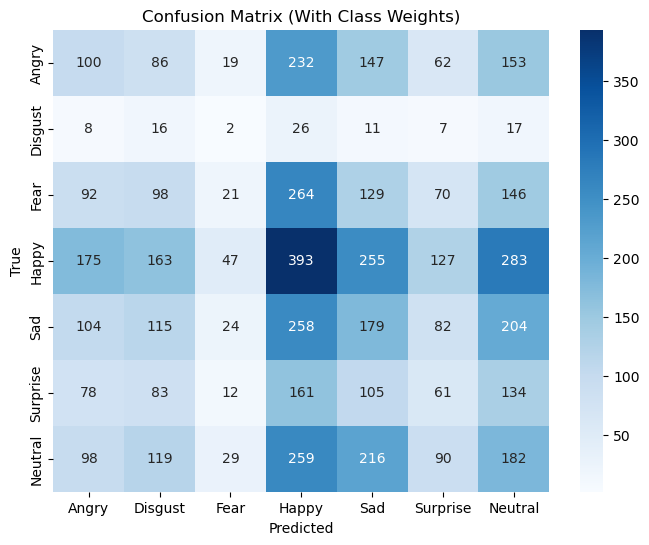

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotion_map.values(),
            yticklabels=emotion_map.values())
plt.title("Confusion Matrix (With Class Weights)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [24]:
# Classification Report 
print("Classification Report (With Class Weights):\n")
print(classification_report(
    y_val_true, y_val_pred_classes,
    target_names=emotion_map.values(),
    zero_division=0   # averts warnings for missing classes
))

Classification Report (With Class Weights):

              precision    recall  f1-score   support

       Angry       0.15      0.13      0.14       799
     Disgust       0.02      0.18      0.04        87
        Fear       0.14      0.03      0.04       820
       Happy       0.25      0.27      0.26      1443
         Sad       0.17      0.19      0.18       966
    Surprise       0.12      0.10      0.11       634
     Neutral       0.16      0.18      0.17       993

    accuracy                           0.17      5742
   macro avg       0.15      0.15      0.13      5742
weighted avg       0.17      0.17      0.16      5742



# Grad-CAM EXPLAINABILITY

In [25]:
!pip install opencv-python

  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
deeplake 3.9.51 requires numpy==1.26.4, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


In [26]:
import cv2

In [35]:
def get_gradcam_heatmap(model, image, layer_name=None):
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break

    # Force a forward pass so the graph is built
    _ = model(image)

    # Now build grad model safely
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)

    return heatmap, class_idx.numpy()


# DEPLOYMENT: API AND WEB APP

In [34]:
# Save model
model.save("my_model.keras")